# Yiwen's CIS 545 Final Project: Amazon Review Analysis and Classification

**Welcome to my Final Project!** For this project, we will be using text from 100,000 reviews from Amazon.com, their timestamps and their ratings. The text has already been pre-processed and is presented as bag of words! Please fasten your seatbelt. Let's rock!

## 0.1 Loading the Packages

The first thing on our list is usually installing or importing the packages we needed. 

In [ ]:
# Load the Packages

%%capture
!pip install -U gensim
!pip install urllib2

# check gensim version (make sure the version is 3.8.1)
import gensim
gensim.__version__

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from datetime import *
from operator import itemgetter

# Warnings about versions are sometimes annoying
# We can use the function below to hide them

import warnings
warnings.filterwarnings('ignore')

## 0.2 Importing the data

Our next step is to prepare our ingrediants for the analysis --- the Amazon reviews, their timestamps and ratings.

In [ ]:
#Introduce our data

%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [ ]:
#Read our data

reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow), 1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## 0.3 Loading pre-built functions

In the next few cells, we are going to load some functions written by us in HW4. There are going to be valuable for our analysis.

- The `convert_times` function should take in the entire `review_times` vector at once. It should return a new pandas `Series` object made from `review_times` but the entries should be of type `datetime` or `Timestamp`.

- The `densify` function transform a sparse matrix to a dense matrix. It prepares the data for Machine Learning algorithms.

- The `make-tfidf` function transform the bag of words to tf-idf presentation by converting our counts into TF-IDF scores.

- The `evaluate_rf_model` functions construct a random forest model with the given inputs X and y. It contains 3 components

    1.   Training/Test Data Split: we randomly select 20% of X, y as our test data
    2.   Construct a Random Forest model with 70 estimators, random state 1911
    3.   Run the model on our test data and determine the accuracy





In [ ]:
def convert_times(reviews_times):
    # TODO #
    res = []
    for var in reviews_times:
      res.append(datetime.fromtimestamp(var))
    return pd.Series(res)

In [ ]:
def densify(sparse, columns):
    res = np.zeros([len(sparse), columns])
    count = 0
    for title in sparse:
      for i in range(len(title)):
        res[count,title[i][0]] += title[i][1]
      count += 1
    return res

In [ ]:
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow, normalize=True)
    return model[reviews_bow]

In [ ]:
def evaluate_rf_model(X, y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    # TODO #
    rfor.fit(X_train,y_train)
    return rfor.score(X_test, y_test)

## 0.4 Prepare/Pre-process the Data

Just one last step before we embark our journary! This part contains x steps.

1. Convert our text data to Tf-idf presentation
2. Convert our timestamp data to the datetime type
3. Run PCA on our data and pick the 40 most informative features (word tokens in our case). This stops our ipynb from crushing since our original data is BIGG!


In [ ]:
#Convert Count-Bag-of-Words to Tf-idf Presenation

reviews_tfidf = make_tfidf(reviews_bow)

In [ ]:
#Convert our timestamp data to the datetime type

reviews_times = convert_times(reviews_times)

In [ ]:
#Run PCA on our data and pick the 40 most informative features

model_lsi = LsiModel(reviews_tfidf, id2word= reviews_dict, num_topics=40)
dense = densify(model_lsi[reviews_tfidf], 40)

In [ ]:
#Take a look at the shape of the matrix we generated

dense.shape

(100000, 40)

# 1.0 Get Started

The first thing we are going to do is to try multiple Machine Learning Algorithms to using text data and text data only. In the next section, we will conduct analysis on the timestamp data and conducted features with them.

In section 1.0, we are going to try 4 different models on our data.
- Linear Regression (With L2-Regularization)
- Support Vector Machine (One vs. One)
- Support Vector Machine (One vs. the Rest)
- Neural Network with Keras

###1.0.0 Preparing Training/Test Data

Before constructing any model, let's conduct training/test data split first. We take 20% of the data as test data and use random state 1911.

In [ ]:
# Train-Test Split (Ratio: 0.2) --> For Random Forest and SVM

X_train, X_test, y_train, y_test = ms.train_test_split(dense, y, test_size=0.2, random_state = 1911)

# Train-Test Split (Ratio: 0.2) --> For Neural Network
## Prepare the y by one-hot encoding it.

y_nn = pd.get_dummies(y).values
X_train_nn, X_test_nn, y_train_nn, y_test_nn = ms.train_test_split(dense, y_nn, test_size=0.2, random_state = 1911)

###1.0.1 Linear Regression

The first model we are going to attempt on our dataset is [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Since we mainly use linear regression for classification task, why do we use it here? I can't agree more! We should certainly treat the ratings as discrete values instead of continuous values. If not, then we are making a very bold assumption: a 2-star comment is strictly in the middle of a 1-star comment and 3-star comment.

In [ ]:
def evaluate_linear_model(X_train, X_test, y_train, y_test):
    # add regularization to linear regression model to reduce over-fitting
    lm = linear_model.Ridge(alpha=0.1)
    lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    return lm.score(X_test, y_test), pred

Let's take at look at our accuracy for the linear model. Emmm, around 47.5% is not too bad, since random guessing gives us 20% accuracys for 5 labels. **However**, are we even sure that are our prediction? Oh, our predicted label of the first sample is 2.76. Could we give a 2.76 stars rating on Amazon? Nope. In addition, the accuracy of this model is determined with MSE, so it doesn't mean anything in our cases. **Therefore, we should know our data before diving into any algorithms, even though many of them are very powerful.** 

In [ ]:
linear_acc, pred = evaluate_linear_model(X_train, X_test, y_train, y_test)
print("The accuracy for Linear Regression is: ", linear_acc)
print("Your predicted label of the first sample is: ", pred[0])

The accuracy for Linear Regression is:  0.4750492687955433
Your predicted label of the first sample is:  2.760944407408921


###1.0.2 Support Vector Machine (One vs. One)

The first metrics does not work for our data... :` (

It is totally fine! Let's do some classification using one of the most powerful algorithm --- Support Vector Machine (**SVM**). [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) finds support vectors(data) that construct a hyperplace which separate data with distinct labels the best. It is very useful in multi-label classification.

The first kind of SVM we are going to run is called One vs. One SVM. It means that we are going to build multiple classifers. To be more specific, we are going to build 10 (5 chooses 2) classifiers. Each tells us if a comment is 1-star or 2-star, 1-star or 3-star, etc.

In [ ]:
from sklearn import svm

def evaluate_svm_model_one_vs_one(X_train, y_train, X_test, y_test):
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train,y_train)
    return clf.score(X_test, y_test)

Wow! The accuracy is very good. We correctly classify over 75% of the data!

In [ ]:
evaluate_svm_model_one_vs_one(X_train, y_train, X_test, y_test)

0.7582

The second kind of SVM we are going to run is called One vs. the Rest SVM. This model should takes less time than the OvO SVM since it will our construct 5 classifiers, one for each class. Each classifer tells us if a comment is 1-star or not? is 2-star or not? etc. 

In [ ]:
def evaluate_svm_model_one_vs_rest(X_train, y_train, X_test, y_test):
    clf = svm.SVC(decision_function_shape='ovr')
    clf.fit(X_train,y_train)
    return clf.score(X_test, y_test)

The accuracies of OvR and OvO SVMs are the both above 75%.

In [ ]:
# Let's evaluate the OvO SVM

evaluate_svm_model_one_vs_rest(X_train, y_train, X_test, y_test)

0.7582

### 1.0.3 Neural Network with Keras

High Energy Ahead! Warning!

Let's try one of the state-of-the-art algorithms for Natural Language Processing and Computer Vision---the Neural Network. It is a very complex model that contains multiple layers, so it tends to be too difficult to interpret. Nonetheless, it works very well, and it's promising to learn more about this algorithm. In addition, there is a derivative of Neural Network called Recurrent Neural Network. It not only has everything from the Neural Network, but also take the squences of words in a review into account. However, since our data's original presentation is count-bag-of-word, we cannot retrieve the sequence.  

In [ ]:
# Import packages for Neural Network

from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

def evaluate_nn_model(X_train, y_train, X_test, y_test):
  # Design the layers

  # Random Dropout to prevent overfitting
  model = Sequential()
  model.add(Dropout(0.1, input_shape=(40,)))

  # Core Layes
  model.add(Dense(120, activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Configures the model for training
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  accs = model.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_split = 0.2)

  return accs, model

In [ ]:
accuracies, nn_model= evaluate_nn_model(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

Train on 64000 samples, validate on 16000 samples
Epoch 1/30
64000/64000 [==============================] - 5s 85us/step - loss: 0.7647 - acc: 0.7419 - val_loss: 0.6122 - val_acc: 0.7788
Epoch 2/30
64000/64000 [==============================] - 5s 81us/step - loss: 0.6372 - acc: 0.7730 - val_loss: 0.5886 - val_acc: 0.7886
Epoch 3/30
64000/64000 [==============================] - 5s 79us/step - loss: 0.6152 - acc: 0.7805 - val_loss: 0.5793 - val_acc: 0.7897
Epoch 4/30
64000/64000 [==============================] - 5s 80us/step - loss: 0.5964 - acc: 0.7877 - val_loss: 0.5723 - val_acc: 0.7939
Epoch 5/30
64000/64000 [==============================] - 5s 80us/step - loss: 0.5853 - acc: 0.7921 - val_loss: 0.5645 - val_acc: 0.7961
Epoch 6/30
64000/64000 [==============================] - 5s 80us/step - loss: 0.5778 - acc: 0.7948 - val_loss: 0.5498 - val_acc: 0.8019
Epoch 7/30
64000/64000 [==============================] - 5s 80us/step - loss: 0.5713 - acc: 0.7972 - val_loss: 0.5477 - val_acc

Let's take a look at the structure of our model!

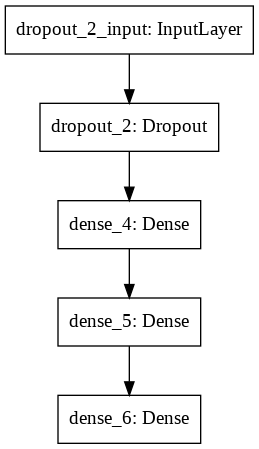

In [ ]:
#Let's take a look at our model structure

from keras.utils import plot_model
plot_model(nn_model)

How does NN makes decisions? The next two cell reveal this information. NN returns a probability of a comment belonging to each of the 5 labels. We will choose the one with highest probability.

In [ ]:
#Explain how NN predicts

pred = nn_model.predict(X_test_nn)
print("The prediction looks like this: ", pred[0])
labels = [1,2,3,4,5]
pred = [labels[np.argmax(item)] for item in pred]

The prediction looks like this:  [4.0715584e-03 9.8431695e-01 5.9470045e-04 8.5295066e-03 2.4872764e-03]


Yea, above 81%! The performance of Neural Network is really good! The great performance is achieved by the complexity of the model. Should we use a complex, multi-layer models all the time? The answer is **It depends**. Text tends to be one of difficult kinds of data to analyze. Therefore, I think NN is a great model which serves our purpose!

In [ ]:
accuracy_score(pred, y_test)

0.81725

We can also take a look at how losses change as number of epoches increases. We only ran 30 epoches.

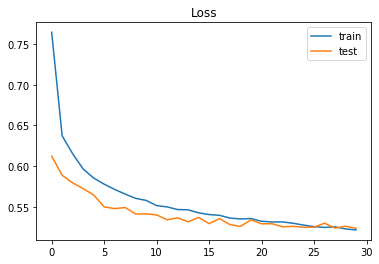

In [ ]:
plt.title('Loss')
plt.plot(accuracies.history['loss'], label='train')
plt.plot(accuracies.history['val_loss'], label='test')
plt.legend()
plt.show();

#2.0 Timestamp Exploratory Data Analysis

We have seen many fancy model in the previous section, but don't forget we have another valuable piece of information we haven't used yet: 
the **timestamp** of each review. Lets dig in to it!

### 2.0.1 Exploration on Years
The first thing we wanna do is to extract the year and month information from the datetime objects. Of course, we can also extract hour information (possibly not minute and seconds lol), but using year and month for now is a great first step. Let's take a look.

In [ ]:
#Extract Year/Month Data

review_times_year = reviews_times.apply(lambda x: x.year)
review_times_month = reviews_times.apply(lambda x: x.month)

Let's look at **year** first. Oops! For some years, we have limited data, and over-generization is a bad practice. For instance, we only have 3 samples in 2001, 25 samples in 2002, and 57 samples in 2003. It is now wise to generalize the pattern of a full year only based on few samples.

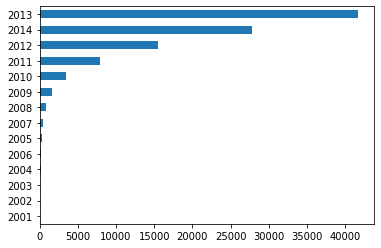

In [ ]:
review_times_year.value_counts(sort=True, ascending=True).plot(kind='barh')

Thus, we choose to keep the years with at least 500 reviews (year 2008~2014). With certainly amount of data, we are more confident before making any claims.

In [ ]:
# Count >= 500 year 2008-2014

# Using Text Data Combimed with Year data

qualified_year_X = []
qualified_year_y = []
qualified_year_reference = []

X = dense

# Let's store all the data from year 2008 to year 2014
zipped = list(zip(X, review_times_year, y))
for i in range(len(zipped)):
  if zipped[i][1] >= 2008:
    qualified_year_X.append(zipped[i][0])
    qualified_year_reference.append(zipped[i][1])
    qualified_year_y.append(zipped[i][2])

In [ ]:
# Extract Data By Year

X_2008 = []
y_2008 = []

X_2009 = []
y_2009 = []

X_2010 = []
y_2010 = []

X_2011 = []
y_2011 = []

X_2012 = []
y_2012 = []

X_2013 = []
y_2013 = []

X_2014 = []
y_2014 = []

zipped_qualified = list(zip(qualified_year_X, qualified_year_reference, qualified_year_y))
for item in zipped_qualified:
  if item[1] == 2008:
    X_2008.append(item[0])
    y_2008.append(item[2])
  if item[1] == 2009:
    X_2009.append(item[0])
    y_2009.append(item[2])
  if item[1] == 2010:
    X_2010.append(item[0])
    y_2010.append(item[2])
  if item[1] == 2011:
    X_2011.append(item[0])
    y_2011.append(item[2])
  if item[1] == 2012:
    X_2012.append(item[0])
    y_2012.append(item[2])
  if item[1] == 2013:
    X_2013.append(item[0])
    y_2013.append(item[2])
  if item[1] == 2014:
    X_2014.append(item[0])
    y_2014.append(item[2])
  
print("Check if we miss any samples: ", not (len(zipped_qualified) == len(X_2008) + len(X_2009) + len(X_2010) + len(X_2011) + len(X_2012) + len(X_2013) + len(X_2014)))

Check if we miss any samples:  False


OK! Now let's check if the ratio of different ratings are consistant throughout the year.

<Figure size 1280x960 with 0 Axes>

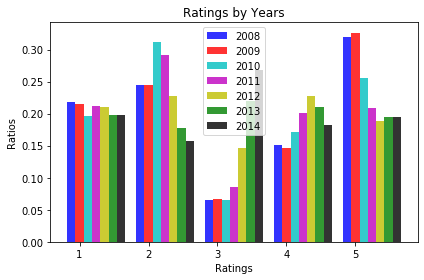

In [ ]:
from collections import Counter

rating_counts_2008 = tuple([val/sum(list(Counter(y_2008).values())) for val in list(Counter(y_2008).values())])
rating_counts_2009 = tuple([val/sum(list(Counter(y_2009).values())) for val in list(Counter(y_2009).values())])
rating_counts_2010 = tuple([val/sum(list(Counter(y_2010).values())) for val in list(Counter(y_2010).values())])
rating_counts_2011 = tuple([val/sum(list(Counter(y_2011).values())) for val in list(Counter(y_2011).values())])
rating_counts_2012 = tuple([val/sum(list(Counter(y_2012).values())) for val in list(Counter(y_2012).values())])
rating_counts_2013 = tuple([val/sum(list(Counter(y_2013).values())) for val in list(Counter(y_2013).values())])
rating_counts_2014 = tuple([val/sum(list(Counter(y_2014).values())) for val in list(Counter(y_2014).values())])

from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

# create plot
n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.12
opacity = 0.8

rects1 = plt.bar(index, rating_counts_2008, bar_width,
alpha=opacity,
color='b',
label='2008')

rects2 = plt.bar(index + bar_width, rating_counts_2009, bar_width,
alpha=opacity,
color='r',
label='2009')

rects3 = plt.bar(index + bar_width*2, rating_counts_2010, bar_width,
alpha=opacity,
color='c',
label='2010')

rects4 = plt.bar(index + bar_width*3, rating_counts_2011, bar_width,
alpha=opacity,
color='m',
label='2011')

rects5 = plt.bar(index + bar_width*4, rating_counts_2012, bar_width,
alpha=opacity,
color='y',
label='2012')

rects6 = plt.bar(index + bar_width*5, rating_counts_2013, bar_width,
alpha=opacity,
color='g',
label='2013')

rects7 = plt.bar(index + bar_width*6, rating_counts_2014, bar_width,
alpha=opacity,
color='k',
label='2014')

plt.xlabel('Ratings')
plt.ylabel('Ratios')
plt.title('Ratings by Years')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5'))
plt.legend()

plt.tight_layout()
plt.show()

Probably not. We find that the ratio of 1-star ratings are similar across the years. Nevertheless, for the other ratings, the distribution varies throughout the years. For instance, as year increases, the ratio of 3-star ratings increases and the ratio of 5-star ratings decreases.
This tells us year may be a power piece of information that we can add to our model.

Before that, there is something interesting we could do. Is it possible for us to use model build with data in, for example, 2008, to predict the labels with data in the future years? How well will it perform? Let's try it out! For each year between 2008 to 2011, we will build NN models using the same structure as in 1.0.3.

In [ ]:
# Adaptation of the Code for this Purpose

def evaluate_nn_model_year(X, y):
  # Train-Test Split
  X = np.asarray(X)
  y = np.asarray(y)
  X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
  y_train = pd.get_dummies(y_train).values
  
  # Design the layers
  # Random Dropout to prevent overfitting
  model = Sequential()
  model.add(Dropout(0.1, input_shape=(40,)))

  # Core Layes
  model.add(Dense(120, activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Configures the model for training
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.2)

  pred = model.predict(X_test)
  labels = [1,2,3,4,5]
  pred = [labels[np.argmax(item)] for item in pred]
  test_acc = accuracy_score(pred, y_test)
  print("The test accuracy is: ", test_acc)
  return model, test_acc

#### 2.0.1.1 Neural Network Model for 2008

In [ ]:
nn_model_2008, test_acc_2008 = evaluate_nn_model_year(X_2008, y_2008)

Train on 555 samples, validate on 139 samples
Epoch 1/50
555/555 [==============================] - 0s 782us/step - loss: 1.5956 - acc: 0.3748 - val_loss: 1.5751 - val_acc: 0.4532
Epoch 2/50
555/555 [==============================] - 0s 95us/step - loss: 1.5582 - acc: 0.4541 - val_loss: 1.5405 - val_acc: 0.4317
Epoch 3/50
555/555 [==============================] - 0s 90us/step - loss: 1.5142 - acc: 0.4739 - val_loss: 1.4972 - val_acc: 0.4460
Epoch 4/50
555/555 [==============================] - 0s 122us/step - loss: 1.4603 - acc: 0.4937 - val_loss: 1.4448 - val_acc: 0.4748
Epoch 5/50
555/555 [==============================] - 0s 92us/step - loss: 1.3932 - acc: 0.5586 - val_loss: 1.3847 - val_acc: 0.5180
Epoch 6/50
555/555 [==============================] - 0s 96us/step - loss: 1.3216 - acc: 0.5928 - val_loss: 1.3150 - val_acc: 0.5827
Epoch 7/50
555/555 [==============================] - 0s 89us/step - loss: 1.2441 - acc: 0.6288 - val_loss: 1.2406 - val_acc: 0.6043
Epoch 8/50
555/555 [=

The test accuracy of the model for year 2008 predicting its own data is 86.2%. Very impressive. How does it performs on future years?

In [ ]:
labels = [1,2,3,4,5]
test_acc_future = []

#2009 

pred_2009 = nn_model_2008.predict(np.asarray(X_2009))
pred_2009 = [labels[np.argmax(item)] for item in pred_2009]
test_acc_2009 = accuracy_score(pred_2009, y_2009)
test_acc_future.append(test_acc_2009)

#2010 

pred_2010 = nn_model_2008.predict(np.asarray(X_2010))
pred_2010 = [labels[np.argmax(item)] for item in pred_2010]
test_acc_2010 = accuracy_score(pred_2010, y_2010)
test_acc_future.append(test_acc_2010)

#2011 

pred_2011 = nn_model_2008.predict(np.asarray(X_2011))
pred_2011 = [labels[np.argmax(item)] for item in pred_2011]
test_acc_2011 = accuracy_score(pred_2011, y_2011)
test_acc_future.append(test_acc_2011)

#2012 

pred_2012 = nn_model_2008.predict(np.asarray(X_2012))
pred_2012 = [labels[np.argmax(item)] for item in pred_2012]
test_acc_2012 = accuracy_score(pred_2012, y_2012)
test_acc_future.append(test_acc_2012)

#2013 

pred_2013 = nn_model_2008.predict(np.asarray(X_2013))
pred_2013 = [labels[np.argmax(item)] for item in pred_2013]
test_acc_2013 = accuracy_score(pred_2013, y_2013)
test_acc_future.append(test_acc_2013)

#2014 

pred_2014 = nn_model_2008.predict(np.asarray(X_2014))
pred_2014 = [labels[np.argmax(item)] for item in pred_2014]
test_acc_2014 = accuracy_score(pred_2014, y_2014)
test_acc_future.append(test_acc_2014)

Interesting. The model works well predicting the ratings from next year. In addition, the model has a great performance on the year after the next year. Let's see if the pattern holds.

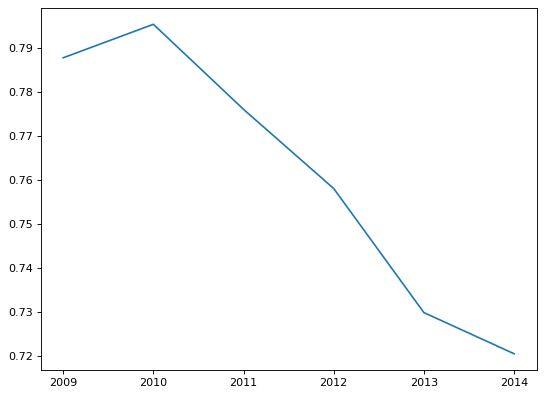

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(2009, 2015), test_acc_future)

#### 2.0.1.2 Neural Network Model for 2009

In [ ]:
nn_model_2009, test_acc_2009 = evaluate_nn_model_year(X_2009, y_2009)

Train on 1006 samples, validate on 252 samples
Epoch 1/50
1006/1006 [==============================] - 1s 507us/step - loss: 1.5745 - acc: 0.3280 - val_loss: 1.5388 - val_acc: 0.3333
Epoch 2/50
1006/1006 [==============================] - 0s 94us/step - loss: 1.4947 - acc: 0.3668 - val_loss: 1.4525 - val_acc: 0.3651
Epoch 3/50
1006/1006 [==============================] - 0s 100us/step - loss: 1.3926 - acc: 0.3797 - val_loss: 1.3547 - val_acc: 0.4048
Epoch 4/50
1006/1006 [==============================] - 0s 96us/step - loss: 1.2814 - acc: 0.4950 - val_loss: 1.2417 - val_acc: 0.6151
Epoch 5/50
1006/1006 [==============================] - 0s 93us/step - loss: 1.1569 - acc: 0.6392 - val_loss: 1.1108 - val_acc: 0.6548
Epoch 6/50
1006/1006 [==============================] - 0s 92us/step - loss: 1.0217 - acc: 0.6869 - val_loss: 0.9879 - val_acc: 0.6865
Epoch 7/50
1006/1006 [==============================] - 0s 89us/step - loss: 0.9031 - acc: 0.7068 - val_loss: 0.8976 - val_acc: 0.7262
Epoch 

The test accuracy of the model for year 2008 predicting its own data is 82.9%. Very nice. How does it performs on future years?

In [ ]:
labels = [1,2,3,4,5]
test_acc_future = []

#2010 

pred_2010 = nn_model_2009.predict(np.asarray(X_2010))
pred_2010 = [labels[np.argmax(item)] for item in pred_2010]
test_acc_2010 = accuracy_score(pred_2010, y_2010)
test_acc_future.append(test_acc_2010)

#2011 

pred_2011 = nn_model_2009.predict(np.asarray(X_2011))
pred_2011 = [labels[np.argmax(item)] for item in pred_2011]
test_acc_2011 = accuracy_score(pred_2011, y_2011)
test_acc_future.append(test_acc_2011)

#2012 

pred_2012 = nn_model_2009.predict(np.asarray(X_2012))
pred_2012 = [labels[np.argmax(item)] for item in pred_2012]
test_acc_2012 = accuracy_score(pred_2012, y_2012)
test_acc_future.append(test_acc_2012)

#2013 

pred_2013 = nn_model_2009.predict(np.asarray(X_2013))
pred_2013 = [labels[np.argmax(item)] for item in pred_2013]
test_acc_2013 = accuracy_score(pred_2013, y_2013)
test_acc_future.append(test_acc_2013)

#2014 

pred_2014 = nn_model_2009.predict(np.asarray(X_2014))
pred_2014 = [labels[np.argmax(item)] for item in pred_2014]
test_acc_2014 = accuracy_score(pred_2014, y_2014)
test_acc_future.append(test_acc_2014)

We observes that the performance of the model decreases over the years.

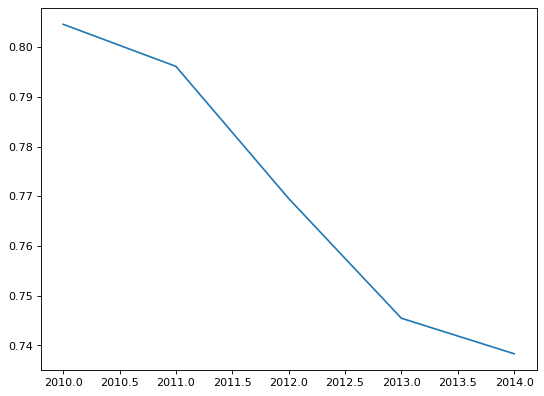

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(2010, 2015, 1),test_acc_future)

#### 2.0.1.3 Neural Network Model for 2010

In [ ]:
nn_model_2010, test_acc_2010 = evaluate_nn_model_year(X_2010, y_2010)

Train on 2194 samples, validate on 549 samples
Epoch 1/50
2194/2194 [==============================] - 1s 291us/step - loss: 1.5555 - acc: 0.3500 - val_loss: 1.4638 - val_acc: 0.3880
Epoch 2/50
2194/2194 [==============================] - 0s 85us/step - loss: 1.3687 - acc: 0.4257 - val_loss: 1.2020 - val_acc: 0.5628
Epoch 3/50
2194/2194 [==============================] - 0s 93us/step - loss: 1.1070 - acc: 0.6522 - val_loss: 0.9132 - val_acc: 0.7596
Epoch 4/50
2194/2194 [==============================] - 0s 94us/step - loss: 0.8775 - acc: 0.7261 - val_loss: 0.7476 - val_acc: 0.7577
Epoch 5/50
2194/2194 [==============================] - 0s 90us/step - loss: 0.7640 - acc: 0.7411 - val_loss: 0.6780 - val_acc: 0.7705
Epoch 6/50
2194/2194 [==============================] - 0s 88us/step - loss: 0.7092 - acc: 0.7543 - val_loss: 0.6168 - val_acc: 0.7796
Epoch 7/50
2194/2194 [==============================] - 0s 90us/step - loss: 0.6916 - acc: 0.7507 - val_loss: 0.6211 - val_acc: 0.7869
Epoch 8

The test accuracy of the model for year 2010 predicting its own data is 84.5%. Very nice. How does it performs on future years?

In [ ]:
labels = [1,2,3,4,5]
test_acc_future = []

#2011 

pred_2011 = nn_model_2010.predict(np.asarray(X_2011))
pred_2011 = [labels[np.argmax(item)] for item in pred_2011]
test_acc_2011 = accuracy_score(pred_2011, y_2011)
test_acc_future.append(test_acc_2011)

#2012 

pred_2012 = nn_model_2010.predict(np.asarray(X_2012))
pred_2012 = [labels[np.argmax(item)] for item in pred_2012]
test_acc_2012 = accuracy_score(pred_2012, y_2012)
test_acc_future.append(test_acc_2012)

#2013 

pred_2013 = nn_model_2010.predict(np.asarray(X_2013))
pred_2013 = [labels[np.argmax(item)] for item in pred_2013]
test_acc_2013 = accuracy_score(pred_2013, y_2013)
test_acc_future.append(test_acc_2013)

#2014 

pred_2014 = nn_model_2010.predict(np.asarray(X_2014))
pred_2014 = [labels[np.argmax(item)] for item in pred_2014]
test_acc_2014 = accuracy_score(pred_2014, y_2014)
test_acc_future.append(test_acc_2014)

Once again, we observes that the performance is decreasing over the years.

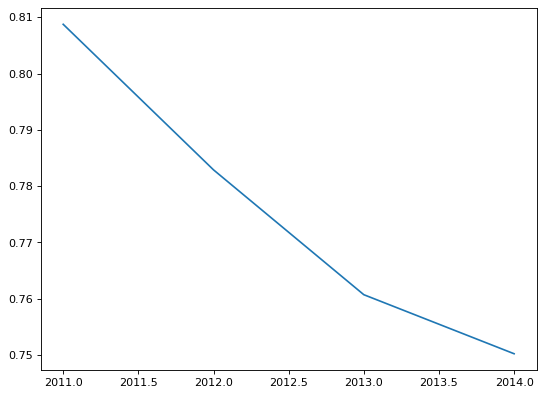

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(2011, 2015, 1), test_acc_future)

####2.0.1.4 Neural Network Model for 2011

In [ ]:
nn_model_2011, test_acc_2011 = evaluate_nn_model_year(X_2011, y_2011)

Train on 5072 samples, validate on 1269 samples
Epoch 1/50
5072/5072 [==============================] - 1s 239us/step - loss: 1.4216 - acc: 0.4491 - val_loss: 1.1027 - val_acc: 0.7108
Epoch 2/50
5072/5072 [==============================] - 0s 85us/step - loss: 0.9206 - acc: 0.7125 - val_loss: 0.6894 - val_acc: 0.7683
Epoch 3/50
5072/5072 [==============================] - 0s 87us/step - loss: 0.7118 - acc: 0.7522 - val_loss: 0.5666 - val_acc: 0.7975
Epoch 4/50
5072/5072 [==============================] - 0s 81us/step - loss: 0.6483 - acc: 0.7666 - val_loss: 0.5485 - val_acc: 0.7991
Epoch 5/50
5072/5072 [==============================] - 0s 88us/step - loss: 0.6260 - acc: 0.7741 - val_loss: 0.5199 - val_acc: 0.8219
Epoch 6/50
5072/5072 [==============================] - 0s 84us/step - loss: 0.6206 - acc: 0.7800 - val_loss: 0.5168 - val_acc: 0.8172
Epoch 7/50
5072/5072 [==============================] - 0s 79us/step - loss: 0.6116 - acc: 0.7790 - val_loss: 0.5139 - val_acc: 0.8180
Epoch 

The test accuracy of the model for year 2008 predicting its own data is 82.8%. Very nice. How does it performs on future years?

In [ ]:
labels = [1,2,3,4,5]
test_acc_future = []

#2012 

pred_2012 = nn_model_2011.predict(np.asarray(X_2012))
pred_2012 = [labels[np.argmax(item)] for item in pred_2012]
test_acc_2012 = accuracy_score(pred_2012, y_2012)
test_acc_future.append(test_acc_2012)

#2013 

pred_2013 = nn_model_2011.predict(np.asarray(X_2013))
pred_2013 = [labels[np.argmax(item)] for item in pred_2013]
test_acc_2013 = accuracy_score(pred_2013, y_2013)
test_acc_future.append(test_acc_2013)

#2014 

pred_2014 = nn_model_2011.predict(np.asarray(X_2014))
pred_2014 = [labels[np.argmax(item)] for item in pred_2014]
test_acc_2014 = accuracy_score(pred_2014, y_2014)
test_acc_future.append(test_acc_2014)

Guess we see the pattern here!

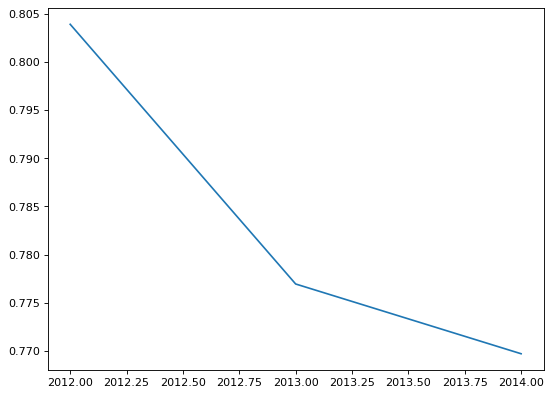

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(2012, 2015, 1),test_acc_future)

Everyone hopes make the correct prediction regarding the future. Based on our data, it seems that the performance of a model diminish overtime across the future years. This makes senses becuase customer behavior changes across years, and it is interesting simply by looking at them. Due to the limited time, I could not go further, but it can certainly be a subject of future work related to fields such as behavior economics.

##2.0.2 Exploration on Month

Let's take a look at Month now. Hopefully we can find some more insights from the data.

At a glance, it seems that we have less reviews from the second half of the year (July-November). Let's take a look at the distribution of the ratios of different ratings.

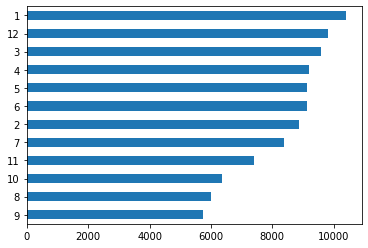

In [ ]:
review_times_month.value_counts(sort=True, ascending=True).plot(kind='barh')

Let's assemble the data based on month.

In [ ]:
# Extract Data By Month

X_Jan = []
y_Jan = []

X_Feb = []
y_Feb = []

X_Mar = []
y_Mar = []

X_Apr = []
y_Apr = []

X_May = []
y_May = []

X_Jun = []
y_Jun = []

X_Jul = []
y_Jul = []

X_Aug = []
y_Aug = []

X_Sep = []
y_Sep = []

X_Oct = []
y_Oct = []

X_Nov = []
y_Nov = []

X_Dec = []
y_Dec = []


zipped = list(zip(X, review_times_month, y))

for item in zipped:
  if item[1] == 1:
    X_Jan.append(item[0])
    y_Jan.append(item[2])
  if item[1] == 2:
    X_Feb.append(item[0])
    y_Feb.append(item[2])
  if item[1] == 3:
    X_Mar.append(item[0])
    y_Mar.append(item[2])
  if item[1] == 4:
    X_Apr.append(item[0])
    y_Apr.append(item[2])
  if item[1] == 5:
    X_May.append(item[0])
    y_May.append(item[2])
  if item[1] == 6:
    X_Jun.append(item[0])
    y_Jun.append(item[2])
  if item[1] == 7:
    X_Jul.append(item[0])
    y_Jul.append(item[2])
  if item[1] == 8:
    X_Aug.append(item[0])
    y_Aug.append(item[2])
  if item[1] == 9:
    X_Sep.append(item[0])
    y_Sep.append(item[2])
  if item[1] == 10:
    X_Oct.append(item[0])
    y_Oct.append(item[2])
  if item[1] == 11:
    X_Nov.append(item[0])
    y_Nov.append(item[2])
  if item[1] == 12:
    X_Dec.append(item[0])
    y_Dec.append(item[2])

  
print("Check if we miss any samples: ", not (len(zipped) == len(X_Jan) + len(X_Feb) + len(X_Mar) + len(X_Apr) + len(X_May) + len(X_Jun) + len(X_Jul) + len(X_Aug) + len(X_Sep) + len(X_Oct) + len(X_Nov) + len(X_Dec)))

Check if we miss any samples:  False


Since we have 12 different classes, one for each month, it would be super ugly to put the on the same plot, and the color is not enough (Seriously? They only have 8 colors!). I generated two plots, one for half of a year. Let's take a look!

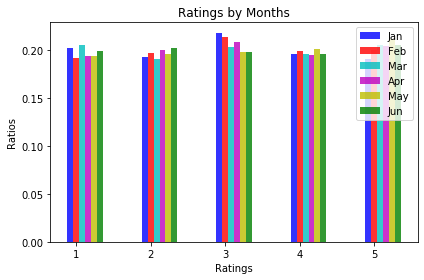

In [ ]:
from collections import Counter

#Count the number of ratings in each month

rating_counts_Jan = tuple([val/sum(list(Counter(y_Jan).values())) for val in list(Counter(y_Jan).values())])
rating_counts_Feb = tuple([val/sum(list(Counter(y_Feb).values())) for val in list(Counter(y_Feb).values())])
rating_counts_Mar = tuple([val/sum(list(Counter(y_Mar).values())) for val in list(Counter(y_Mar).values())])
rating_counts_Apr = tuple([val/sum(list(Counter(y_Apr).values())) for val in list(Counter(y_Apr).values())])
rating_counts_May = tuple([val/sum(list(Counter(y_May).values())) for val in list(Counter(y_May).values())])
rating_counts_Jun = tuple([val/sum(list(Counter(y_Jun).values())) for val in list(Counter(y_Jun).values())])
rating_counts_Jul = tuple([val/sum(list(Counter(y_Jul).values())) for val in list(Counter(y_Jul).values())])
rating_counts_Aug = tuple([val/sum(list(Counter(y_Aug).values())) for val in list(Counter(y_Aug).values())])
rating_counts_Sep = tuple([val/sum(list(Counter(y_Sep).values())) for val in list(Counter(y_Sep).values())])
rating_counts_Oct = tuple([val/sum(list(Counter(y_Oct).values())) for val in list(Counter(y_Oct).values())])
rating_counts_Nov = tuple([val/sum(list(Counter(y_Nov).values())) for val in list(Counter(y_Nov).values())])
rating_counts_Dec = tuple([val/sum(list(Counter(y_Dec).values())) for val in list(Counter(y_Dec).values())])

# create plot for Jan to Jun

n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.08
opacity = 0.8

rects1 = plt.bar(index, rating_counts_Jan, bar_width,
alpha=opacity,
color='b',
label='Jan')

rects2 = plt.bar(index + bar_width, rating_counts_Feb, bar_width,
alpha=opacity,
color='r',
label='Feb')

rects3 = plt.bar(index + bar_width*2, rating_counts_Mar, bar_width,
alpha=opacity,
color='c',
label='Mar')

rects4 = plt.bar(index + bar_width*3, rating_counts_Apr, bar_width,
alpha=opacity,
color='m',
label='Apr')

rects5 = plt.bar(index + bar_width*4, rating_counts_May, bar_width,
alpha=opacity,
color='y',
label='May')

rects6 = plt.bar(index + bar_width*5, rating_counts_Jun, bar_width,
alpha=opacity,
color='g',
label='Jun')

plt.xlabel('Ratings')
plt.ylabel('Ratios')
plt.title('Ratings by Months')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5'))
plt.legend()

plt.tight_layout()
plt.show()

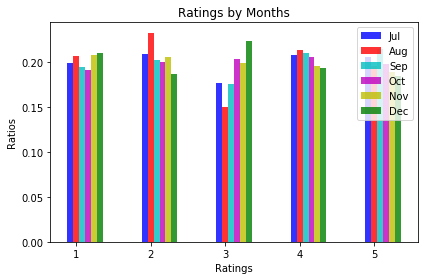

In [ ]:
# create plot for Jul to Dec
n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.08
opacity = 0.8

rects1 = plt.bar(index, rating_counts_Jul, bar_width,
alpha=opacity,
color='b',
label='Jul')

rects2 = plt.bar(index + bar_width, rating_counts_Aug, bar_width,
alpha=opacity,
color='r',
label='Aug')

rects3 = plt.bar(index + bar_width*2, rating_counts_Sep, bar_width,
alpha=opacity,
color='c',
label='Sep')

rects4 = plt.bar(index + bar_width*3, rating_counts_Oct, bar_width,
alpha=opacity,
color='m',
label='Oct')

rects5 = plt.bar(index + bar_width*4, rating_counts_Nov, bar_width,
alpha=opacity,
color='y',
label='Nov')

rects6 = plt.bar(index + bar_width*5, rating_counts_Dec, bar_width,
alpha=opacity,
color='g',
label='Dec')

plt.xlabel('Ratings')
plt.ylabel('Ratios')
plt.title('Ratings by Months')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5'))
plt.legend()

plt.tight_layout()
plt.show()

It seems that the ratio for each rating is around 20% for most of the time, it seems to be last informative than years, but we will still one-hot encoded it and added it to our **Final Model** just to make sure we did not miss anything simply based on assumption.

# 3.0 Final Model

Our final model is a neural network which contains the text data and the one-hot encoding version of month and year. Listen to a song when you run a model. I highly recommend Yitai Wang if you like jazz hip-hop. Here is a [live](https://www.youtube.com/watch?v=TiRacUb_kKk&list=RDMMTa5GwQ49xtk&index=25) of Yitai Wang.

In [ ]:
#One-hot Encoding Month

review_times_month_1hot = pd.get_dummies(review_times_month).values

#One-hot Encoding Year

review_times_year_1hot = pd.get_dummies(review_times_year).values

In [ ]:
print("shape of one-hot encoding month: ", review_times_month_1hot.shape)
print("shape of one-hot encoding year: ", review_times_year_1hot.shape)

shape of one-hot encoding month:  (100000, 12)
shape of one-hot encoding year:  (100000, 14)


In [ ]:
#Merge them using np.hstack

X = np.hstack((dense, review_times_month_1hot))
X = np.hstack((X, review_times_year_1hot))

In [ ]:
#Take a look at its new shape

X.shape

(100000, 66)

In [ ]:
def evaluate_nn_final_model(X, y):
  # Train-Test Split
  X = np.asarray(X)
  y = np.asarray(y)
  X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
  y_train = pd.get_dummies(y_train).values
  
  # Design the layers
  # Random Dropout to prevent overfitting
  model = Sequential()
  model.add(Dropout(0.1, input_shape=(66,)))

  # Core Layes
  model.add(Dense(120, activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Configures the model for training
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.2)

  pred = model.predict(X_test)
  labels = [1,2,3,4,5]
  pred = [labels[np.argmax(item)] for item in pred]
  test_acc = accuracy_score(pred, y_test)
  print("The test accuracy is: ", test_acc)
  return model, test_acc

In [ ]:
evaluate_nn_final_model(X, y)

Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - 6s 92us/step - loss: 0.8641 - acc: 0.6853 - val_loss: 0.6367 - val_acc: 0.7704
Epoch 2/50
64000/64000 [==============================] - 5s 83us/step - loss: 0.6788 - acc: 0.7564 - val_loss: 0.6208 - val_acc: 0.7785
Epoch 3/50
64000/64000 [==============================] - 5s 84us/step - loss: 0.6679 - acc: 0.7605 - val_loss: 0.6145 - val_acc: 0.7805
Epoch 4/50
64000/64000 [==============================] - 5s 83us/step - loss: 0.6554 - acc: 0.7643 - val_loss: 0.6096 - val_acc: 0.7821
Epoch 5/50
64000/64000 [==============================] - 5s 82us/step - loss: 0.6452 - acc: 0.7689 - val_loss: 0.6087 - val_acc: 0.7791
Epoch 6/50
64000/64000 [==============================] - 5s 82us/step - loss: 0.6311 - acc: 0.7726 - val_loss: 0.5999 - val_acc: 0.7849
Epoch 7/50
64000/64000 [==============================] - 5s 82us/step - loss: 0.6236 - acc: 0.7766 - val_loss: 0.5913 - val_acc

(<keras.engine.sequential.Sequential at 0x7f80a7d61048>, 0.81135)

The test accuracy of my final model is 81.14%, slightly lower than the NN model(81.7%) without features generated from time. However, we have a random dropout layer at the beginning of our model, so there is some kind of randomese in them.

#4.0 Conclusion

We completed multiple things in this notebook, including:
- Built multiple machine learning models on text data
  - Linear Regression (BAD)
  - One vs. One SVM
  - One vs. All SVM
  - Neural Network 
- Explored the timestamp data and find some interesting trend
  - Exploration and Findings related to Year and Month. 
  - Data Visualizations
- Constructed our final Neural Network model containing one-hot encoded features enigneered from timestamp

**Thank you for going through this process with me. It is also a great lesson for me as well! Good luck on ur finals!**


###4.0.1 Futurework

As we discussed earlier, we shouldn't treat ratings as continuous values. Instead, they should be treated discretely. In this case, should we design a better metrics for accuracy? Hit-and-Miss is certainly powerful, but when we make an error, this error can have different severity.

To be more specific, if our model predict a comment is 4-star when it is actually 5-star, it is a minor error. In contrast, if our model predict a comment is 1-star when it is actually 5-star, this becomes a very big problem and we should penalize the performance of the model more heavily. This metrics for evaluation could be studied in the future.